# Проект Оптимизация производственных расходов металлургического комбината

<div style="border:solid Chocolate 2px; padding: 40px">
    
Введение: Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. 

Цель проекта: построить модель, которая будет её предсказывать температуру сплава. Заказчик хочет использовать разработанную модель для имитации технологического процесса. 

Описание этапа обработки: <br> Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
<br> <br> 
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»). 
<br> <br> 
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки. 
<br> <br> 
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

Описание данных: <br>
Данные состоят из нескольких файлов, полученных из разных источников:
* data_arc_new.csv — данные об электродах;
* data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
* data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
* data_gas_new.csv — данные о продувке сплава газом;
* data_temp_new.csv — результаты измерения температуры;
* data_wire_new.csv — данные о проволочных материалах (объём);
* data_wire_time_new.csv — данные о проволочных материалах (время).

Файл data_arc_new.csv <br>
* key — номер партии;
* Начало нагрева дугой — время начала нагрева;
* Конец нагрева дугой — время окончания нагрева;
* Активная мощность — значение активной мощности;
* Реактивная мощность — значение реактивной мощности.

Файл data_bulk_new.csv
* key — номер партии;
* Bulk 1 … Bulk 15 — объём подаваемого материала.

Файл data_bulk_time_new.csv
* key — номер партии;
* Bulk 1 … Bulk 15 — время подачи материала.

Файл data_gas_new.csv
* key — номер партии;
* Газ 1 — объём подаваемого газа.

Файл data_temp_new.csv
* key — номер партии;
* Время замера — время замера;
* Температура — значение температуры.

Файл data_wire_new.csv
* key — номер партии;
* Wire 1 … Wire 15 — объём подаваемых проволочных материалов.

Файл data_wire_time_new.csv
* key — номер партии;
* Wire 1 … Wire 15 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

План выполнения проекта:
1. Загрузка данных
2. Исследовательский анализ и предобработка данных
3. Объединение данных
4. Исследовательский анализ и предобработка данных объединённого датафрейма
5. Подготовка данных
6. Обучение моделей машинного обучения
7. Выбор лучшей модели
8. Общий вывод и рекомендации заказчику

## Загрузка данных

In [1]:
!pip install catboost -q
!pip install lightgbm -q

In [2]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import time
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

In [3]:
RANDOM_STATE = 30624 
TEST_SIZE = 0.25

### Загружаю данные и провожу первичный осмотр

Файл data_arc_new.csv

In [4]:
# Загружаю данные и провожу первичный осмотр.
pth1 = '/datasets/data_arc_new.csv'
pth2 = 'data_arc_new.csv'
if os.path.exists(pth1):
    data_arc_new = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_arc_new = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [5]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [6]:
data_arc_new.shape

(14876, 5)

Файл data_bulk_new.csv

In [7]:
pth1 = '/datasets/data_bulk_new.csv'
pth2 = 'data_bulk_new.csv'
if os.path.exists(pth1):
    data_bulk_new = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_bulk_new = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [8]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [9]:
data_bulk_new.shape

(3129, 16)

Файл data_bulk_time_new.csv

In [10]:
pth1 = '/datasets/data_bulk_time_new.csv'
pth2 = 'data_bulk_time_new.csv'
if os.path.exists(pth1):
    data_bulk_time_new = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_bulk_time_new = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [11]:
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [12]:
data_bulk_time_new.shape

(3129, 16)

Файл data_gas_new.csv

In [13]:
pth1 = '/datasets/data_gas_new.csv'
pth2 = 'data_gas_new.csv'
if os.path.exists(pth1):
    data_gas_new = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_gas_new = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [14]:
data_gas_new.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [15]:
data_gas_new.shape

(3239, 2)

Файл data_temp_new.csv

In [16]:
pth1 = '/datasets/data_temp_new.csv'
pth2 = 'data_temp_new.csv'
if os.path.exists(pth1):
    data_temp_new = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_temp_new = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [17]:
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [18]:
data_temp_new.shape

(18092, 3)

Файл data_wire_new.csv

In [19]:
pth1 = '/datasets/data_wire_new.csv'
pth2 = 'data_wire_new.csv'
if os.path.exists(pth1):
    data_wire_new = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_wire_new = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [20]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
data_wire_new.shape

(3081, 10)

Файл data_wire_time_new.csv

In [22]:
pth1 = '/datasets/data_wire_time_new.csv'
pth2 = 'data_wire_time_new.csv'
if os.path.exists(pth1):
    data_wire_time_new = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_wire_time_new = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [23]:
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
data_wire_time_new.shape

(3081, 10)

### Выводы из первичного осмотра данных

Выводы из первичного осмотра данных:
* загрузил файлы с данными в семь датафреймов
* содержание датафреймов соответствует заявленому описанию данных, кроме того, что в файлах data_wire_new и data_wire_time_new заявлено в описании, что Wire 1 … Wire 15 признаков будет 15, а их 9шт.

## Исследовательский анализ и предобработка данных

In [25]:
# функция для построения ящика с усами и гистограммы (для числовых признаков)
def boxplot_(df, column):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.boxplot(data=df, x=column, ax=axes[0])
    axes[0].set_title(f'Ящик с усами для столбца "{column}"')
    axes[0].set_ylabel('Количество')
    sns.histplot(data=df, x=column, kde=True, ax=axes[1])
    axes[1].set_title(f'Гистограмма для столбца "{column}"')
    axes[1].set_ylabel('Частота')
    plt.tight_layout()
    plt.show()

### data_arc_new

In [26]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [27]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [28]:
# привел к кириллическому_змеиному_языку
data_arc_new.columns = data_arc_new.columns.str.lower().str.replace(' ', '_')
data_arc_new.columns

Index(['key', 'начало_нагрева_дугой', 'конец_нагрева_дугой',
       'активная_мощность', 'реактивная_мощность'],
      dtype='object')

In [29]:
data_arc_new.duplicated().sum()

0

In [30]:
data_arc_new['начало_нагрева_дугой'] = pd.to_datetime(data_arc_new['начало_нагрева_дугой'])
data_arc_new['конец_нагрева_дугой'] = pd.to_datetime(data_arc_new['конец_нагрева_дугой'])

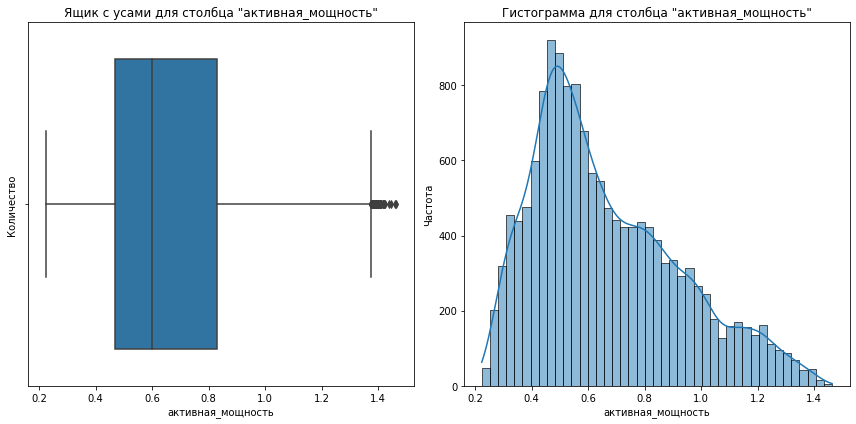

In [31]:
boxplot_(data_arc_new, 'активная_мощность')

In [33]:
# Обработаем аномальное значение в 9780 наблюдении.
data_arc_new[data_arc_new['реактивная_мощность']<-600]

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [34]:
data_arc_new[data_arc_new['key']==2116]

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


In [35]:
data_arc_new2 = data_arc_new[data_arc_new['реактивная_мощность']>-600]

In [36]:
# вычеслим значение ячейки с помощью пропопрцииональной зависимости активной и реактивной мощности
# через их средние значения и текущее значение активной мощности
data_arc_new2['реактивная_мощность'].mean()*0.705344/data_arc_new2['активная_мощность'].mean()

0.5184221542595583

In [37]:
data_arc_new.loc[9780, 'реактивная_мощность'] = 0.518422

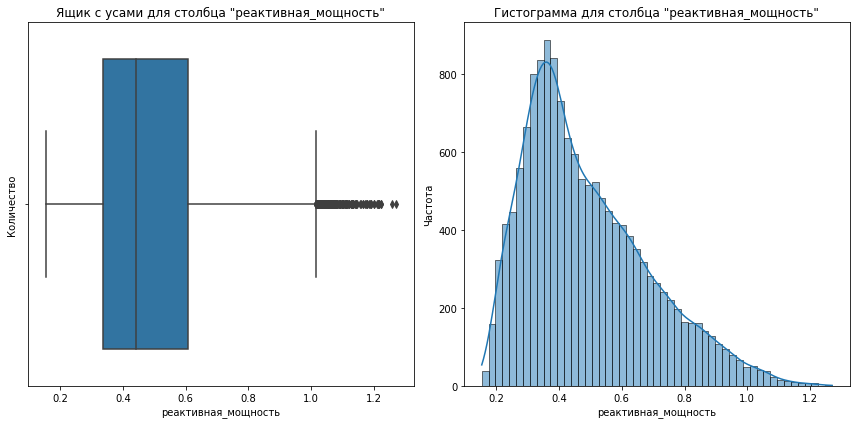

In [38]:
boxplot_(data_arc_new, 'реактивная_мощность')

### data_bulk_new

In [39]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [40]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [41]:
data_bulk_new.columns = data_bulk_new.columns.str.lower().str.replace(' ', '_')
data_bulk_new.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [42]:
data_bulk_new.duplicated().sum()

0

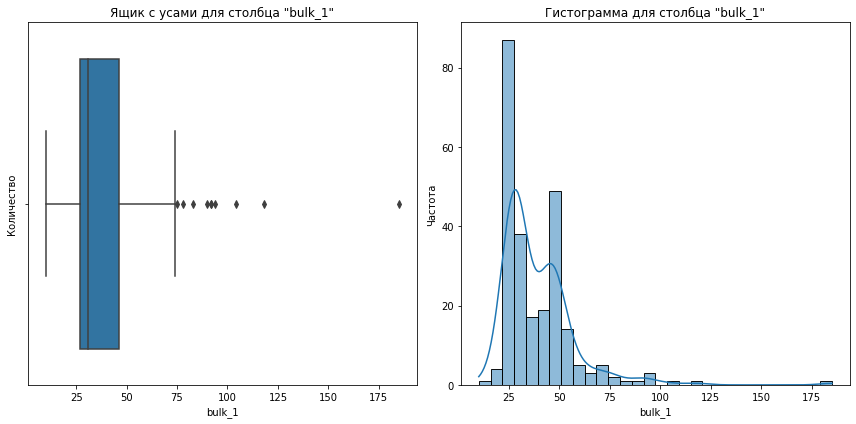

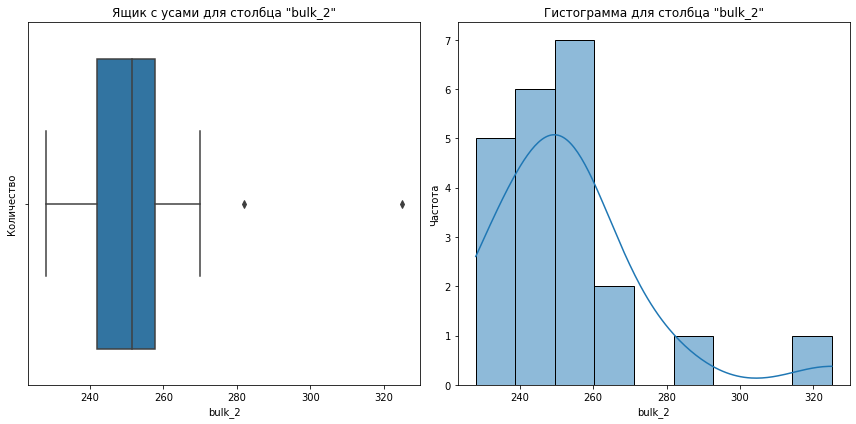

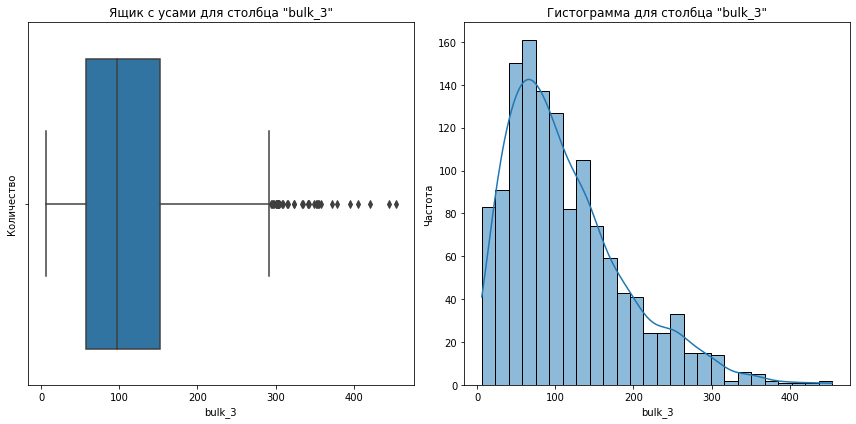

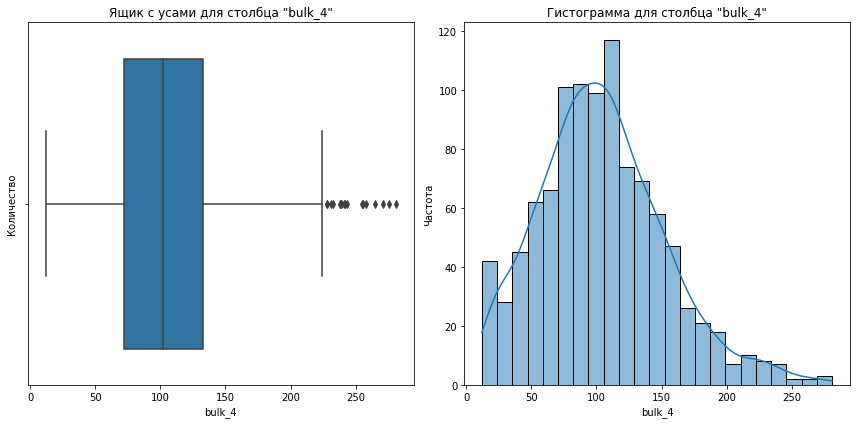

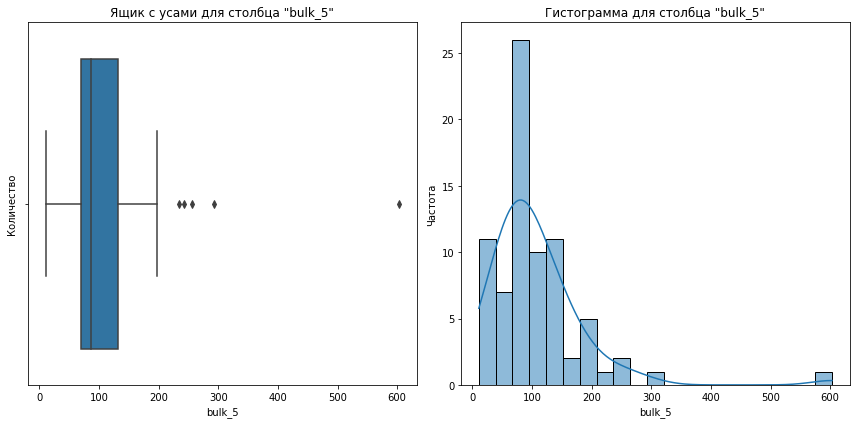

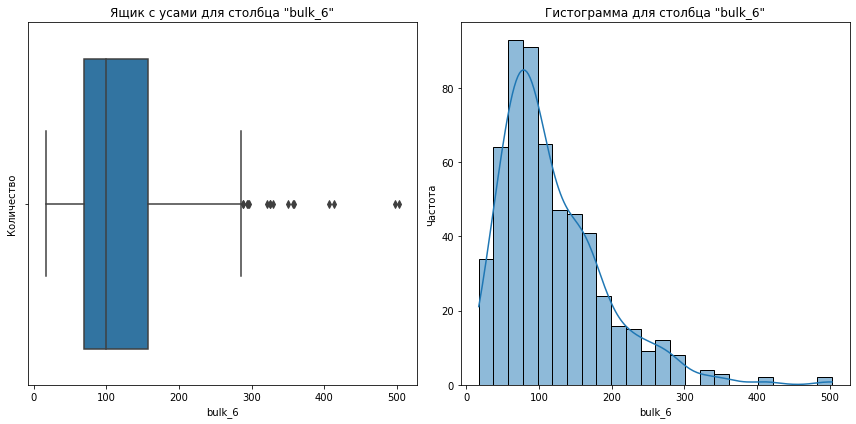

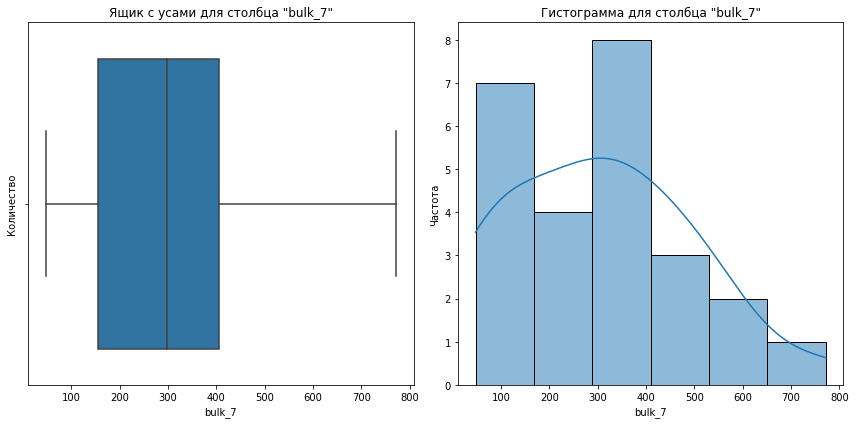

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


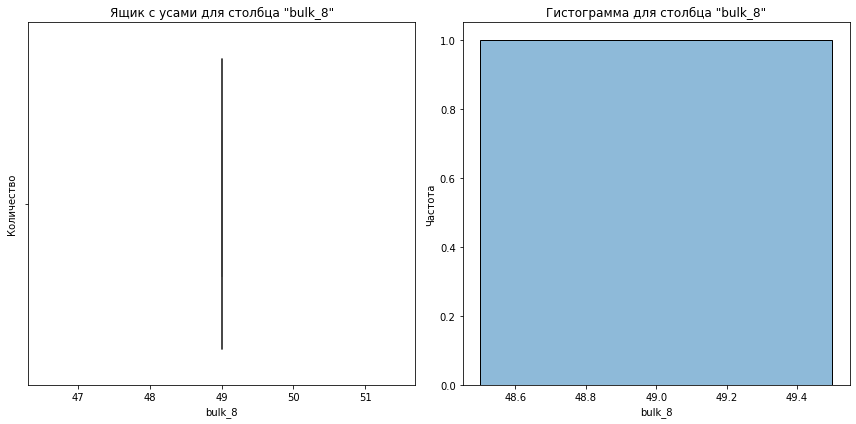

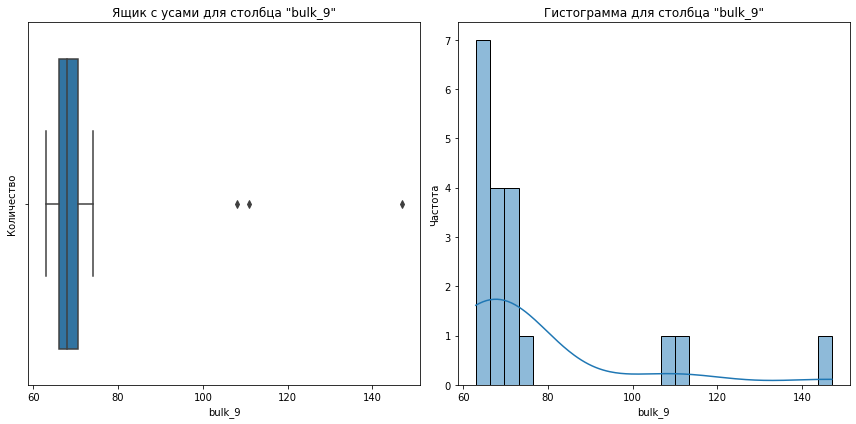

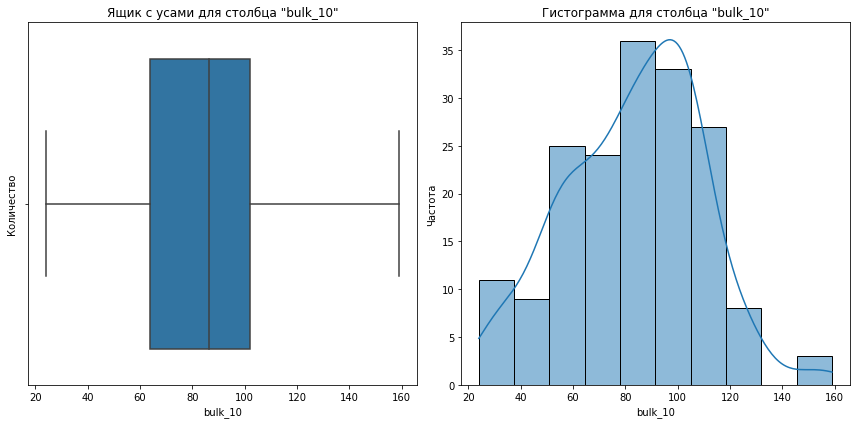

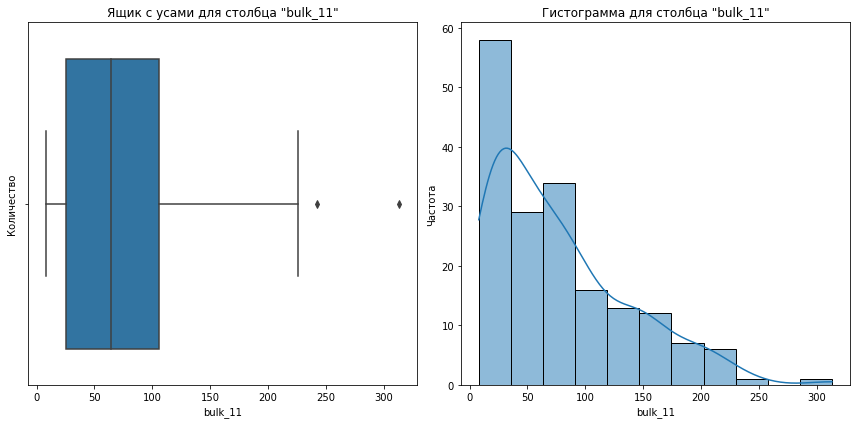

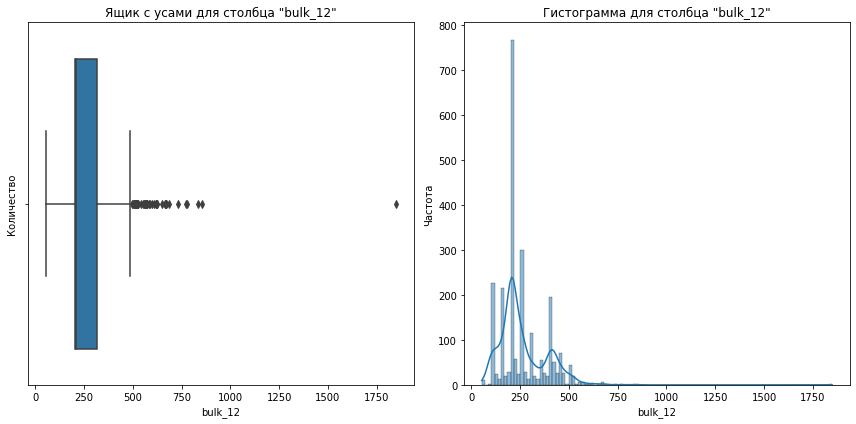

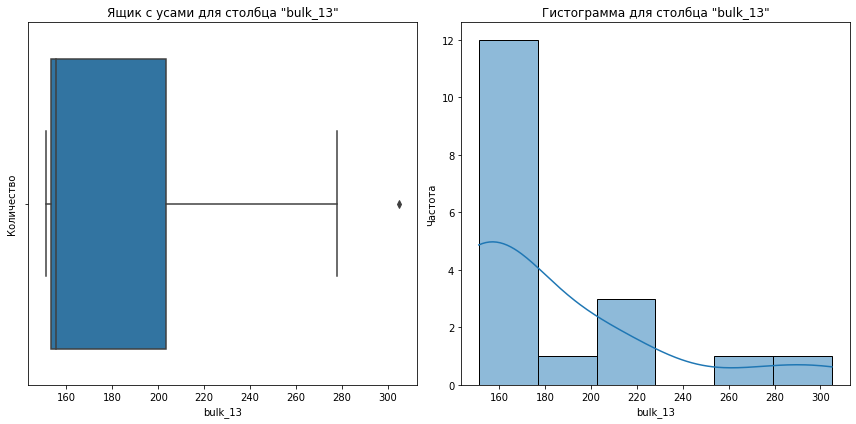

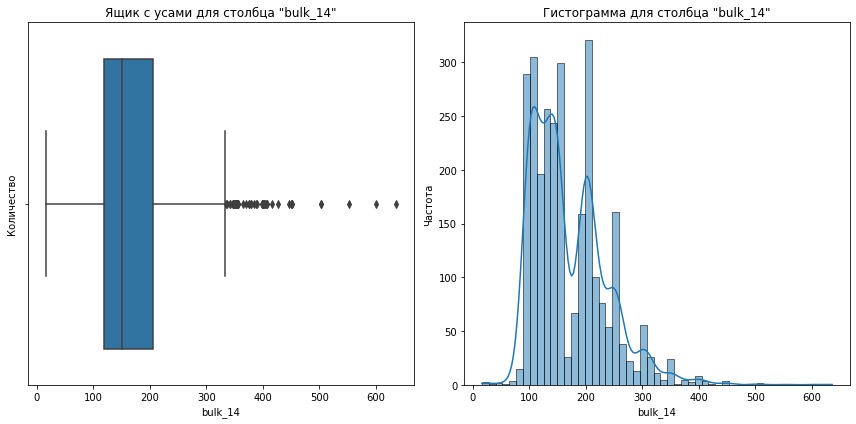

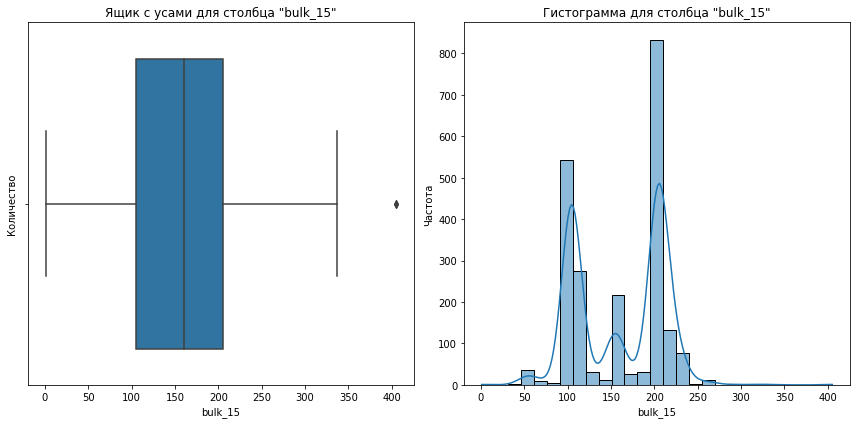

In [43]:
for i in range(1,16):
    boxplot_(data_bulk_new, 'bulk_'+str(i))

In [44]:
# заменил пропуски на ноль
data_bulk_new = data_bulk_new.fillna(0)

In [45]:
data_bulk_new_filtred = data_bulk_new[['key', 'bulk_3', 'bulk_4', 'bulk_12', 'bulk_14', 'bulk_15']]

Оставил в датафрейме признаки, имеющее более 1000 наблюдений (или 30% от общего количества)

### data_bulk_time_new

In [46]:
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [47]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [48]:
data_bulk_time_new.columns = data_bulk_time_new.columns.str.lower().str.replace(' ', '_')
data_bulk_time_new.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [49]:
data_bulk_time_new.duplicated().sum()

0

In [50]:
for i in range(1,16):
    data_bulk_time_new['bulk_'+str(i)] = pd.to_datetime(data_bulk_time_new['bulk_'+str(i)])

Этот датафрейм не планирую использовать при обучении модели


### data_gas_new

In [51]:
data_gas_new.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [52]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [53]:
data_gas_new.columns = data_gas_new.columns.str.lower().str.replace(' ', '_')
data_gas_new.columns

Index(['key', 'газ_1'], dtype='object')

In [54]:
data_gas_new.duplicated().sum()

0

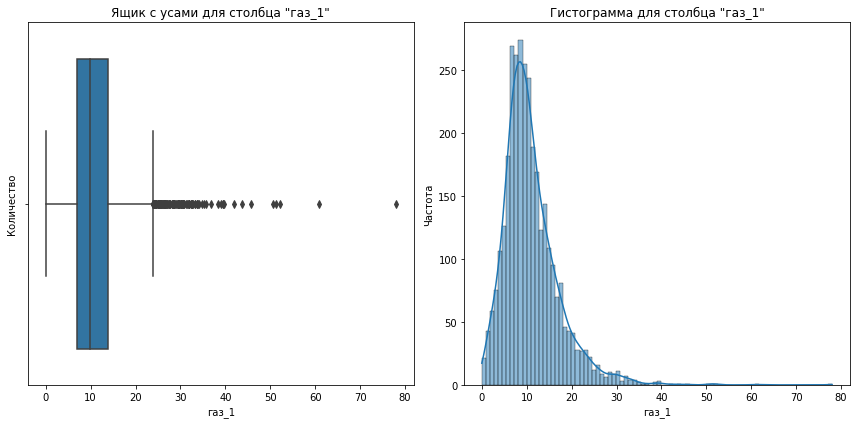

In [55]:
boxplot_(data_gas_new, 'газ_1')

### data_temp_new

In [56]:
data_temp_new.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [57]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [58]:
data_temp_new.columns = data_temp_new.columns.str.lower().str.replace(' ', '_')
data_temp_new.columns

Index(['key', 'время_замера', 'температура'], dtype='object')

In [59]:
data_temp_new['время_замера'] = pd.to_datetime(data_temp_new['время_замера'])

In [60]:
data_temp_new['температура'] = data_temp_new['температура'].fillna(0)

In [61]:
data_temp_new.duplicated().sum()

0

In [62]:
# Создаю сводную таблицу по партиям
data_temp_new_pivot = data_temp_new.pivot_table(
    index=['key'], values=['температура','время_замера'], aggfunc=['first', 'last', 'count'])
data_temp_new_pivot.columns = ['first_time', 'first_temp', 'last_time', 'last_temp', 'count', 'count']
data_temp_new_pivot.head()

,first_time,first_temp,last_time,last_temp,count,count
key,,,,,,
1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,6,6
2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,5,5
3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,6,6
4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,5,5
5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,5,5


In [63]:
#удалим "плохие" партии, там где нет 1го или последнего измерения
len(data_temp_new_pivot.query('last_temp==0')), len(data_temp_new_pivot.query('first_temp==0'))

(739, 0)

In [64]:
data_temp_new_pivot.query('count==1')

,first_time,first_temp,last_time,last_temp,count,count
key,,,,,,
195,2019-05-11 00:01:36,1583.0,2019-05-11 00:01:36,1583.0,1,1
279,2019-05-14 10:13:01,1603.0,2019-05-14 10:13:01,1603.0,1,1


In [65]:
data_temp_new_filtred = data_temp_new_pivot[(~data_temp_new_pivot.index.isin(
    data_temp_new_pivot.query('last_temp==0').index))]
data_temp_new_filtred = data_temp_new_filtred[(~data_temp_new_filtred.index.isin(
    data_temp_new_filtred.query('count==1').index))]

In [66]:
len(data_temp_new_filtred.query('last_temp==0'))

0

In [67]:
len(data_temp_new_filtred.query('count==1'))

0

In [68]:
data_temp_new_filtred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   first_time  2475 non-null   datetime64[ns]
 1   first_temp  2475 non-null   float64       
 2   last_time   2475 non-null   datetime64[ns]
 3   last_temp   2475 non-null   float64       
 4   count       2475 non-null   int64         
 5   count       2475 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 135.4 KB


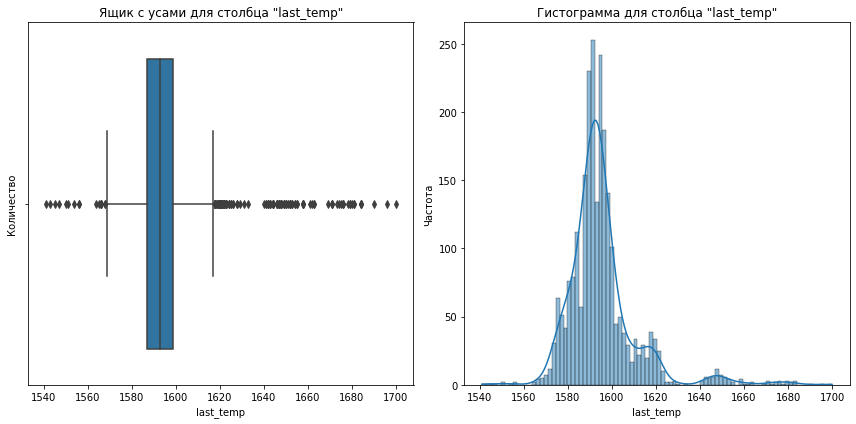

In [69]:
boxplot_(data_temp_new_filtred, 'last_temp')

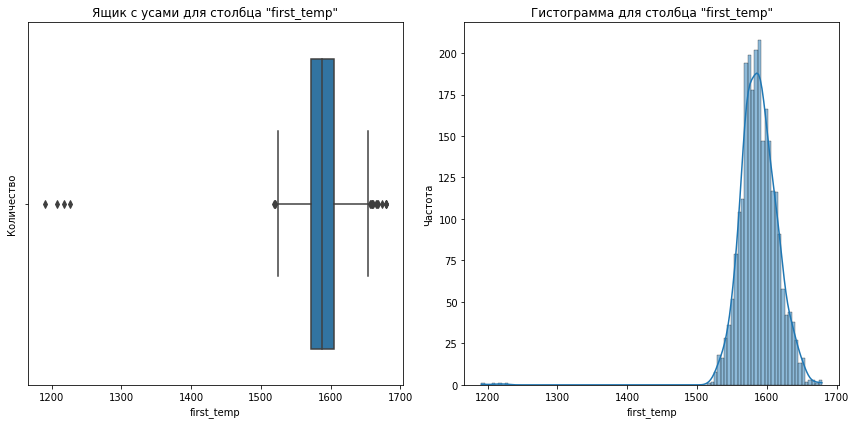

In [70]:
boxplot_(data_temp_new_filtred, 'first_temp')

In [71]:
data_temp_new_filtred.query('first_temp<1300')

,first_time,first_temp,last_time,last_temp,count,count
key,,,,,,
867,2019-06-06 08:03:39,1191.0,2019-06-06 08:48:23,1599.0,8,8
1214,2019-06-18 08:01:03,1208.0,2019-06-18 08:43:56,1591.0,4,4
1619,2019-07-03 02:34:41,1218.0,2019-07-03 02:43:59,1590.0,3,3
2052,2019-07-25 08:49:15,1227.0,2019-07-25 09:27:03,1592.0,6,6


In [72]:
data_temp_new_filtred = data_temp_new_filtred[(~data_temp_new_filtred.index.isin(
    data_temp_new_filtred.query(('first_temp<1300')).index))]

Удалил 4 партии с аномалиями начальных температур менее 1300

### data_wire_new

In [73]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [75]:
data_wire_new.columns = data_wire_new.columns.str.lower().str.replace(' ', '_')
data_wire_new.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [76]:
data_wire_new.duplicated().sum()

0

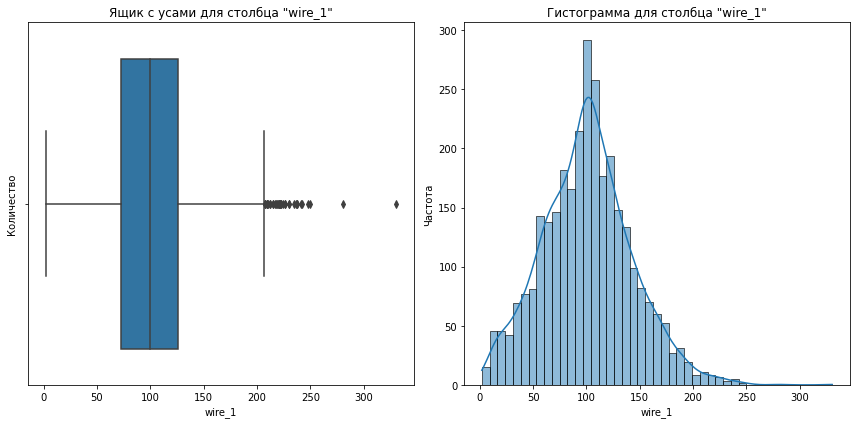

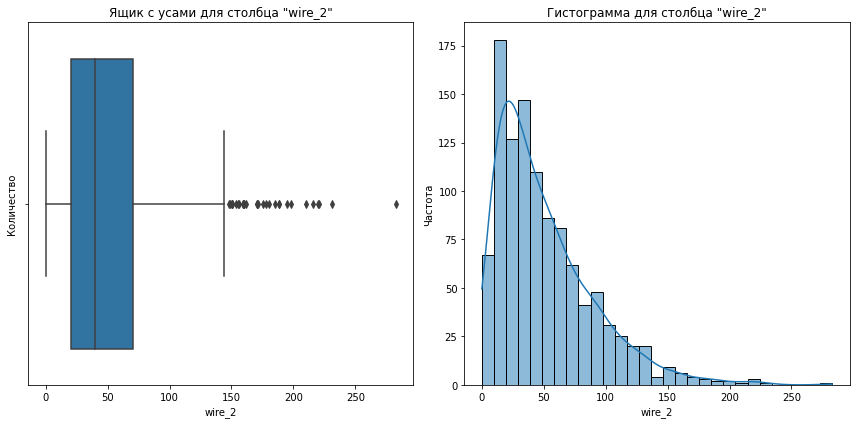

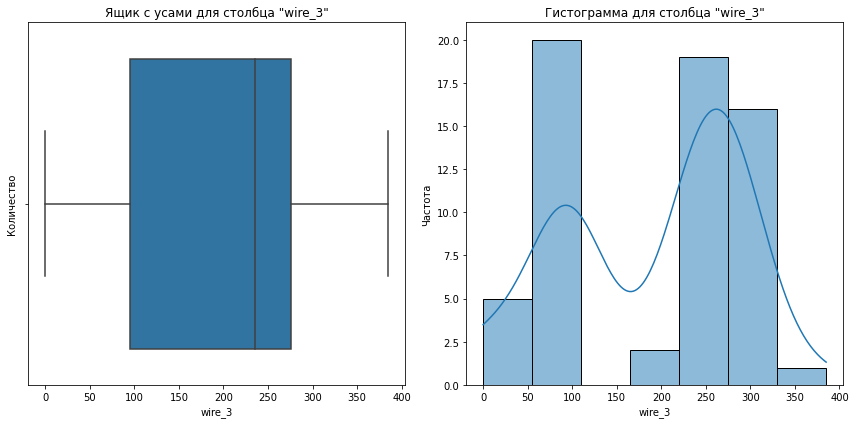

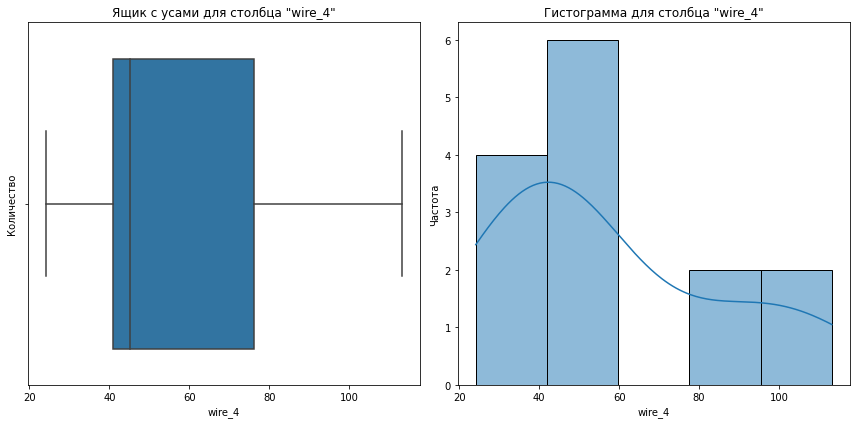

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


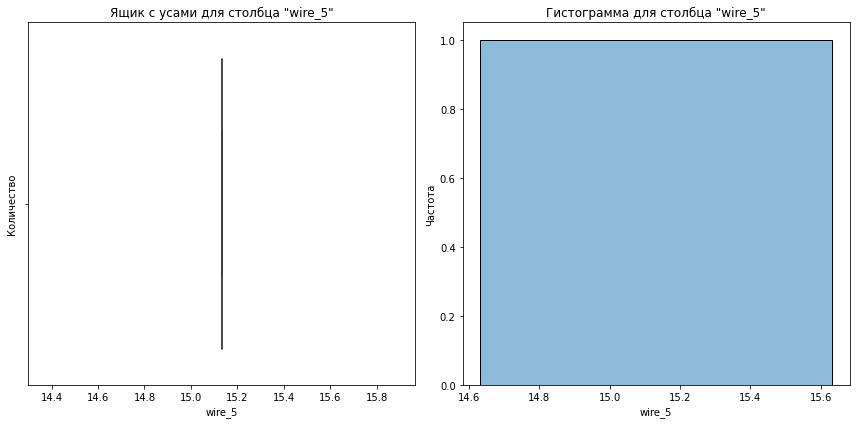

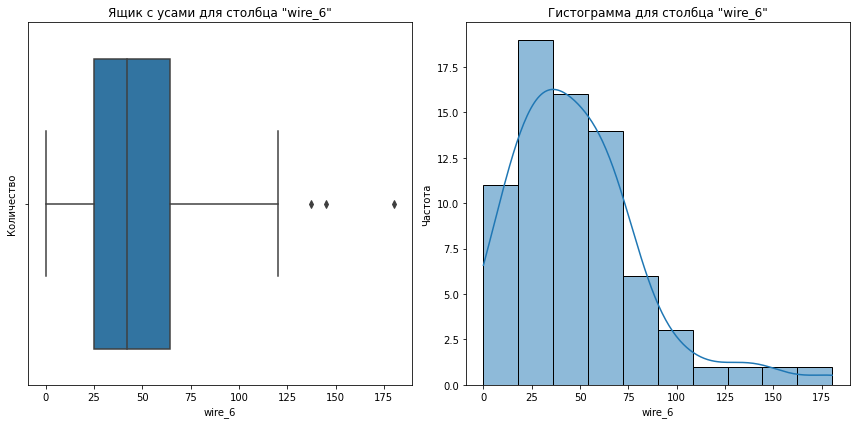

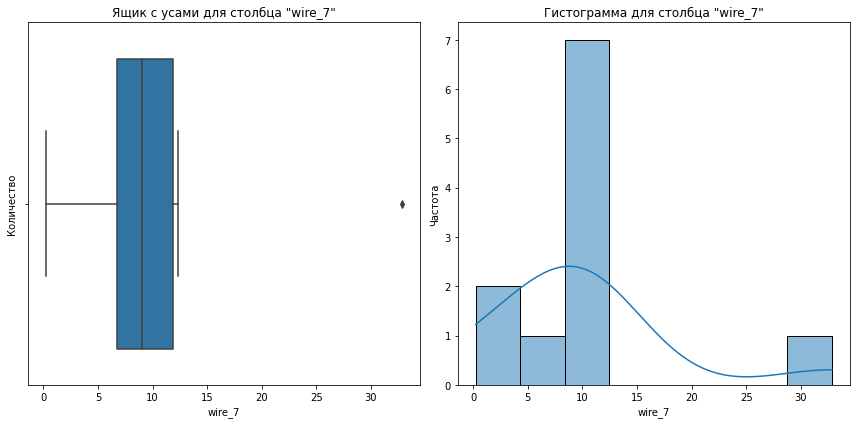

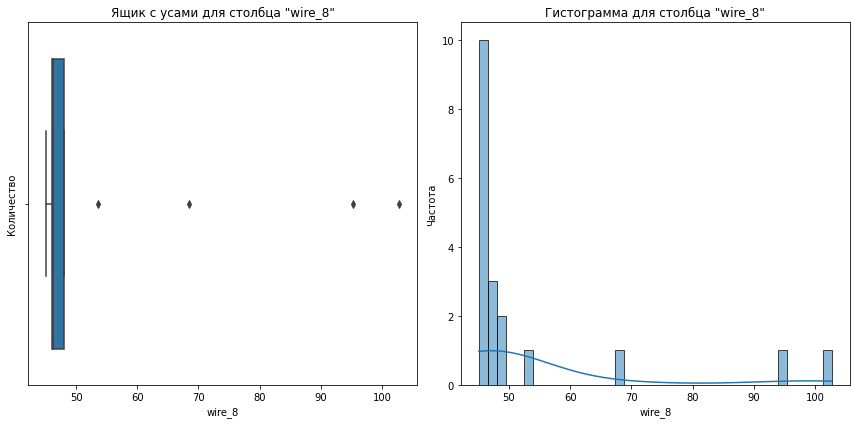

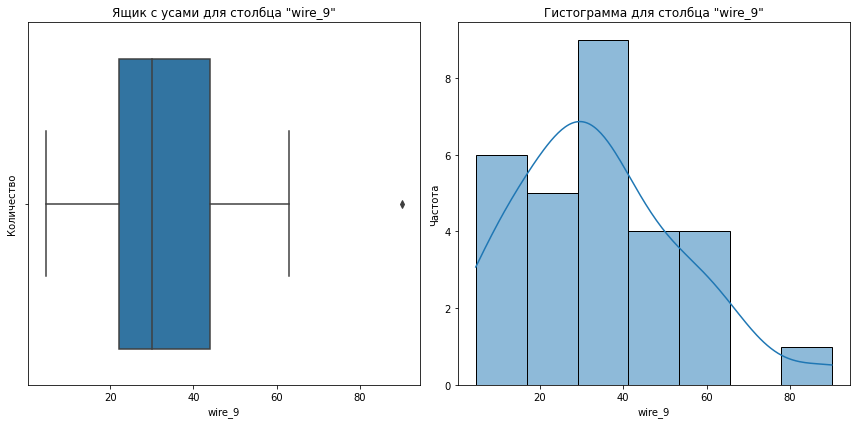

In [77]:
for i in range(1,10):
    boxplot_(data_wire_new, 'wire_'+str(i))

In [78]:
data_wire_new = data_wire_new.fillna(0)

In [79]:
data_wire_new_filtred = data_wire_new[['key', 'wire_1', 'wire_2']]

### data_wire_time_new

In [80]:
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [82]:
data_wire_time_new.columns = data_wire_time_new.columns.str.lower().str.replace(' ', '_')
data_wire_time_new.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [83]:
data_wire_time_new.duplicated().sum()

0

In [84]:
for i in range(1,10):
    data_wire_time_new['wire_'+str(i)] = pd.to_datetime(data_wire_time_new['wire_'+str(i)])

### Выводы из иследовательского анализа

Выводы из иследовательского анализа:
* Датафрейм data_arc_new
  1. В датафрейме всего 14876 объектов.
  2. 5 признаков: key номер партии по этому признаку буду соединять таблицы. Начало и конец нагрева стали преобразовал в тип datatime, но и этого мало для признака, в дальнейшем будем вычеслять дельты времени. Признаки Активная мощность и Реактивная мощность содержат числовые значения.
  3. Датафрейм не содержит пропусков и дупликатов.
  4. Признак Активная мощность данные распределены нормально от 0,2 до 1,4. При этом, вершина «колокола» нормального распределения смещена влево. Пик расположен на значении 0,45. Признак Реактивная мощность данные распределены нормально от 0,2 до 1,2. При этом, вершина «колокола» нормального распределения смещена влево. Пик расположен на значении 0,35.
  5. Есть одно аномальное наблюдение 9780. Для его обработки вычеслил значение ячейки с помощью пропопрцииональной зависимости активной и реактивной мощности через их средние значения и текущее значение активной мощности.
* Датафрейм data_bulk_new
  1. В датафрейме всего 3129 объектов.
  2. 16 признаков: key номер партии. 15 видов сыпучих добавок.
  3. В каждом признаке есть пропуски - это значит в этой операции материал не добовлялся. Некоторые признаки имеют очень мало наблюдений. Например: bulk_2 22шт, bulk_7 25шт, bulk_8 1шт, bulk_13  18шт. Датафрейм не содержит дупликатов.
  4. Оставил в датафрейме признаки, имеющее более 1000 наблюдений (или 30% от общего количества).
  5. Признаки распрелелены нормально со смещение «колокола» влево.
* Датафрейм data_bulk_time_new
  1. В датафрейме всего 3129 объектов, как и в предыдущем.
  2. 16 признаков: key номер партии. 15 времен подачи соответствующик добавок.
  3. В каждом признаке есть пропуски. Датафрейм не содержит дупликатов.
  4. Этот датафрейм не планирую использовать при обучении модели
* Датафрейм data_gas_new
  1. В датафрейме всего 3239 объектов.
  2. 2 признака: key номер партии и объём подаваемого газа.
  3. Датафрейм не содержит пропусков и дупликатов.
* Датафрейм data_temp_new
  1. В датафрейме всего 18092 объектов.
  2. 3 признака: key номер партии. Время замера температуры сплава и его температура
  3. Признак температура имеет пропуски. Их важно обработать, так как в данных содержится целевой признак (измерение темературы в конце каждого цикла) и еще один важный признак (температура в начале каждого цикла). Данные востоновлению не подлежат. Удаляем полностью все наблюдения в тех циклах, в которых отсутствует температура начала цикла или конечная.  Датафрейм не содержит дупликатов.
  4. Признак температура распределен нормально. Есть 4 аномалии - это начальные температуры сплавов. Аномалии удалил.
* Датафрейм data_wire_new
  1. В датафрейме всего 3081 объектов.
  2. 10 признаков: key номер партии. 9 видов сыпучих добавок.
  3. В каждом признаке есть пропуски - это значит в этой операции материал не добовлялся. Некоторые признаки имеют очень мало наблюдений. Датафрейм не содержит дупликатов.
  4. Оставил в датафрейме признаки, имеющее более 1000 наблюдений (или 30% от общего количества).
  5. Признаки распрелелены нормально со смещение «колокола» влево.
* Датафрейм data_wire_time_new
  1. В датафрейме всего 3081 объектов, как и в предыдущем.
  2. 10 признаков: key номер партии. 9 времен подачи соответствующик добавок.
  3. В каждом признаке есть пропуски. Датафрейм не содержит дупликатов.
  4. Этот датафрейм не планирую использовать при обучении модели
* Во всех датафреймах переимменвал столбцы - привел к кириллическому_змеиному_языку.
* Во всех датафреймах разное количество наблюдении. При объединении данных часть наблюдений будет утрачена

## Объединение данных

In [85]:
list = [data_arc_new,
data_bulk_new,
data_bulk_time_new,
data_gas_new,
data_temp_new,
data_wire_new,
data_wire_time_new]

In [86]:
for i in list:
    print(i['key'].nunique(), i['key'].count())

3214 14876
3129 3129
3129 3129
3239 3239
3216 18092
3081 3081
3081 3081


In [87]:
# Для понимания структуры рабочего цикла отобразим все процессы первого цыкла
for i in list:
    print(display(i.query('key==1')))

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


None


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0


None


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43


None


,key,газ_1
0,1,29.749986


None


,key,время_замера,температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0


None


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


None


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


None


### Целевой признак (target)

In [88]:
data_temp_new_filtred.head()

,first_time,first_temp,last_time,last_temp,count,count
key,,,,,,
1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,6,6
2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,5,5
3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,6,6
4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,5,5
5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,5,5


In [89]:
target = data_temp_new_filtred.drop(columns=['first_time','first_temp', 'last_time', 'count', 'count'])
target.columns = ['target']
target.head()

,target
key,
1,1613.0
2,1602.0
3,1599.0
4,1625.0
5,1602.0


### Признак начальная температура (temp_start)

In [90]:
temp_start = data_temp_new_filtred.drop(columns=['first_time','last_temp', 'last_time', 'count', 'count'])
temp_start.columns = ['temp_start']
temp_start.head()

,temp_start
key,
1,1571.0
2,1581.0
3,1596.0
4,1601.0
5,1576.0


### Признак работа operation

In [91]:
data_arc_new.head(7)

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527


In [92]:
data_arc_new['время_нагрева'] = (data_arc_new['конец_нагрева_дугой'] - 
                                 data_arc_new['начало_нагрева_дугой']).astype('timedelta64[s]')

In [93]:
data_arc_new['operation'] = np.sqrt(
    data_arc_new['активная_мощность']**2 + data_arc_new['реактивная_мощность']**2
) * data_arc_new['время_нагрева']

In [94]:
operation = data_arc_new.pivot_table(index=['key'], values='operation', aggfunc='sum')

In [95]:
operation.head()

,operation
key,
1,770.282114
2,481.760005
3,722.837668
4,683.455597
5,512.169934


### Признаки объёмы подаваемого материала bulks

In [96]:
data_bulk_new_filtred.head()

,key,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15
0,1,0.0,43.0,206.0,150.0,154.0
1,2,0.0,73.0,206.0,149.0,154.0
2,3,0.0,34.0,205.0,152.0,153.0
3,4,0.0,81.0,207.0,153.0,154.0
4,5,0.0,78.0,203.0,151.0,152.0


In [97]:
bulks = data_bulk_new_filtred.set_index('key')
bulks.head()

,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15
key,,,,,
1,0.0,43.0,206.0,150.0,154.0
2,0.0,73.0,206.0,149.0,154.0
3,0.0,34.0,205.0,152.0,153.0
4,0.0,81.0,207.0,153.0,154.0
5,0.0,78.0,203.0,151.0,152.0


### Признаки объёмы подаваемых проволочных материалов wires

In [98]:
data_wire_new_filtred.head()

,key,wire_1,wire_2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456


In [99]:
wires = data_wire_new_filtred.set_index('key')
wires.head()

,wire_1,wire_2
key,,
1,60.059998,0.00000
2,96.052315,0.00000
3,91.160157,0.00000
4,89.063515,0.00000
5,89.238236,9.11456


### Признак объём подаваемого газа gas

In [100]:
data_gas_new.head()

,key,газ_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [101]:
gas = data_gas_new.set_index('key')
gas.head()

,газ_1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


### Признак общее время цикла full_time

In [102]:
data_temp_new_filtred.head()

,first_time,first_temp,last_time,last_temp,count,count
key,,,,,,
1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,6,6
2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,5,5
3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,6,6
4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,5,5
5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,5,5


In [103]:
data_temp_new_filtred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 1 to 2499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   first_time  2471 non-null   datetime64[ns]
 1   first_temp  2471 non-null   float64       
 2   last_time   2471 non-null   datetime64[ns]
 3   last_temp   2471 non-null   float64       
 4   count       2471 non-null   int64         
 5   count       2471 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 135.1 KB


In [104]:
data_temp_new_filtred['full_time'] = (
    data_temp_new_filtred['last_time'] - data_temp_new_filtred['first_time']).astype('timedelta64[s]')

In [105]:
full_time = data_temp_new_filtred.drop(columns=['first_time','first_temp', 'last_time', 'last_temp', 'count', 'count'])

In [106]:
full_time.head()

,full_time
key,
1,1714.0
2,1265.0
3,1753.0
4,1220.0
5,1536.0


In [107]:
df = target.join([temp_start, operation, bulks, wires, gas, full_time], how='inner')

In [108]:
(data_temp_new_filtred[data_temp_new_filtred['first_temp']<1300].index).isin(df.index)

array([], dtype=bool)

In [109]:
len(df), len(target), len(temp_start), len(operation), len(bulks), len(wires), len(gas), len(full_time)

(2325, 2471, 2471, 3214, 3129, 3081, 3239, 2471)

### Выводы объединения данных

Выводы объединения данных
Для машинного обучения выделил 7 групп признаков:
* Целевой признак (target) Этот признак находится в датафрейме data_temp_new в столбце температура в ноблюдениях в конце технологического цикла
* Признак начальная температура берем также в датфрейме data_temp_new, только берем измерения проводимые в начале цикла.
* Признак работа получаем в датафрейме data_arc_new по фомуле вычесления Работы  A=sqtr(P**2+Q**2)*t причем все работы в цикле мы тоже складываем. В каждом объекте получем общюю работу.
* Признаки объёмы подаваемого материала bulks
* Признаки объёмы подаваемых проволочных материалов wires
* Признак объём подаваемого газа gas
* Признак общее время цикла full_time вычисляем полное время цикла. Данные берем в data_temp_new. Это разница между конечным и начальным измерением времени.
Во всех датафреймах разное количество наблюдений. При объединении данных часть наблюдений будет утрачена, а именн 2329 объекта

## Исследовательский анализ и предобработка данных объединённого датафрейма

In [110]:
df.corr()

,target,temp_start,operation,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,wire_1,wire_2,газ_1,full_time
target,1.000000,0.301961,0.256326,-0.036767,0.188100,0.267379,0.114520,0.266386,0.317702,-0.206837,0.059036,0.096342
temp_start,0.301961,1.000000,-0.345377,-0.113271,0.165562,-0.079339,-0.180058,-0.062137,0.262946,-0.101012,0.036730,0.210838
operation,0.256326,-0.345377,1.000000,0.089049,-0.021682,0.420855,0.405776,0.272803,0.060854,0.047518,0.354149,0.507303
bulk_3,-0.036767,-0.113271,0.089049,1.000000,-0.295303,0.018409,0.011061,-0.012791,0.037950,0.095025,0.059651,0.023135
bulk_4,0.188100,0.165562,-0.021682,-0.295303,1.000000,0.105505,-0.091238,0.101169,0.298265,-0.267932,0.017521,0.002139
bulk_12,0.267379,-0.079339,0.420855,0.018409,0.105505,1.000000,0.481087,0.614182,0.171090,-0.097866,0.216869,0.209718
bulk_14,0.114520,-0.180058,0.405776,0.011061,-0.091238,0.481087,1.000000,0.264442,-0.052792,0.036891,0.268275,0.173766
bulk_15,0.266386,-0.062137,0.272803,-0.012791,0.101169,0.614182,0.264442,1.000000,0.119366,-0.096044,0.042995,0.099302
wire_1,0.317702,0.262946,0.060854,0.037950,0.298265,0.171090,-0.052792,0.119366,1.000000,-0.069288,0.118173,0.154379
wire_2,-0.206837,-0.101012,0.047518,0.095025,-0.267932,-0.097866,0.036891,-0.096044,-0.069288,1.000000,0.104639,0.060500


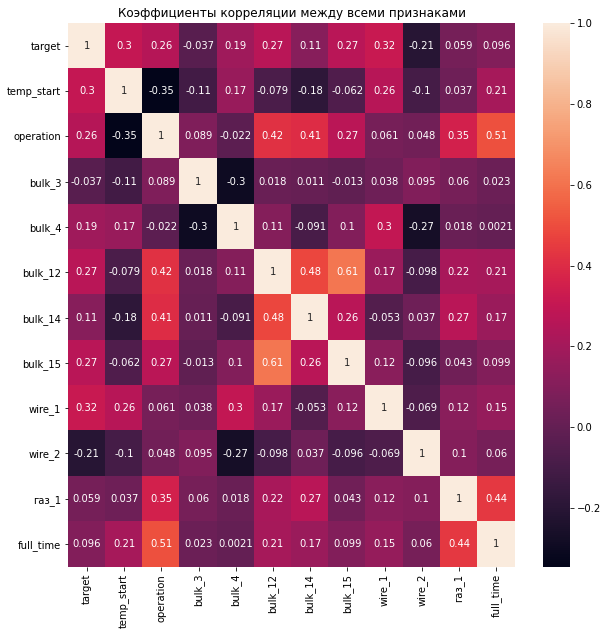

In [111]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)
plt.title('Коэффициенты корреляции между всеми признаками');

Высоких корреляций признаков между собой не наблюдаю.

## Подготовка данных

In [112]:
df.head()

,target,temp_start,operation,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,wire_1,wire_2,газ_1,full_time
key,,,,,,,,,,,,
1,1613.0,1571.0,770.282114,0.0,43.0,206.0,150.0,154.0,60.059998,0.00000,29.749986,1714.0
2,1602.0,1581.0,481.760005,0.0,73.0,206.0,149.0,154.0,96.052315,0.00000,12.555561,1265.0
3,1599.0,1596.0,722.837668,0.0,34.0,205.0,152.0,153.0,91.160157,0.00000,28.554793,1753.0
4,1625.0,1601.0,683.455597,0.0,81.0,207.0,153.0,154.0,89.063515,0.00000,18.841219,1220.0
5,1602.0,1576.0,512.169934,0.0,78.0,203.0,151.0,152.0,89.238236,9.11456,5.413692,1536.0


In [113]:
# выделил целевой признак
features = df.drop(columns='target')
target = df['target']

In [114]:
# Разделил на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size = TEST_SIZE, random_state = RANDOM_STATE, shuffle=True
)
print(len(X_train), len(X_test))

1743 582


In [115]:
(data_temp_new_filtred[data_temp_new_filtred['first_temp']<1300].index).isin(X_test.index)

array([], dtype=bool)

Выводы:
* Выделил целевой признак.
* Разделил данные на тренировочную и тестовую.

## Обучение моделей машинного обучения

Попробую применить модели:

* Линейная регрессия
* Случайный лес
* LGBMRegressor
* CatBoost

In [116]:
tablo = pd.DataFrame([], 
columns=['Linear', 'RandomForest', 'LGBM', 'CatBoost'])

In [117]:
%%time
model = LinearRegression()
params = {'fit_intercept': [True, False]}
grid_lr = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error')
grid_lr.fit(X_train, y_train)
result_l = abs(grid_lr.best_score_)
print(f'MAE: {result_l:.2f}')

MAE: 6.75
CPU times: user 96.2 ms, sys: 51.9 ms, total: 148 ms
Wall time: 106 ms


In [118]:
encoder = StandardScaler()
encoder.fit(X_train)
X_train_ss = encoder.fit_transform(X_train)

In [119]:
%%time
model = LinearRegression()
params = {'fit_intercept': [True, False]}
grid_lr_ohe = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error')
grid_lr_ohe.fit(X_train_ss, y_train)
result_l_ohe = abs(grid_lr_ohe.best_score_)
print(f'MAE: {result_l_ohe:.2f}')

MAE: 6.75
CPU times: user 55.4 ms, sys: 52.8 ms, total: 108 ms
Wall time: 106 ms


Масштабирование линейной модели существенно не повлияло на метрику

In [120]:
%%time
model = RandomForestRegressor()
params = {
    'max_depth': [10, 15, 12],
    'min_samples_split': [3, 4, 6],
    'random_state': [RANDOM_STATE]
}
grid_rf = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error')
grid_rf.fit(X_train, y_train)
result_forest = abs(grid_rf.best_score_)
print(f'MAE: {result_forest:.2f}')

MAE: 6.68
CPU times: user 30.9 s, sys: 54.8 ms, total: 30.9 s
Wall time: 31 s


In [121]:
grid_rf.best_params_

{'max_depth': 10, 'min_samples_split': 4, 'random_state': 30624}

In [122]:
%%time
model = LGBMRegressor()
params = {
    'metric': ['mae'],
    'max_depth': [8, 10, 12],
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.05],
    'random_state': [RANDOM_STATE],
}
grid_lgbm_ = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error', verbose=2)
grid_lgbm_.fit(X_train, y_train)
result_lgbm = abs(grid_lgbm_.best_score_)
print(f'MAE: {result_lgbm:.2f}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END learning_rate=0.001, max_depth=8, metric=mae, num_leaves=10, random_state=30624; total time=   1.0s
[CV] END learning_rate=0.001, max_depth=8, metric=mae, num_leaves=10, random_state=30624; total time=   0.5s
[CV] END learning_rate=0.001, max_depth=8, metric=mae, num_leaves=10, random_state=30624; total time=   1.5s
[CV] END learning_rate=0.001, max_depth=8, metric=mae, num_leaves=10, random_state=30624; total time=   1.2s
[CV] END learning_rate=0.001, max_depth=8, metric=mae, num_leaves=10, random_state=30624; total time=   0.4s
[CV] END learning_rate=0.001, max_depth=8, metric=mae, num_leaves=20, random_state=30624; total time=   1.5s
[CV] END learning_rate=0.001, max_depth=8, metric=mae, num_leaves=20, random_state=30624; total time=   1.3s
[CV] END learning_rate=0.001, max_depth=8, metric=mae, num_leaves=20, random_state=30624; total time=   1.4s
[CV] END learning_rate=0.001, max_depth=8, metric=mae, num_leaves=

In [123]:
grid_lgbm_.best_params_

{'learning_rate': 0.05,
 'max_depth': 10,
 'metric': 'mae',
 'num_leaves': 20,
 'random_state': 30624}

In [124]:
%%time
model = CatBoostRegressor(verbose=False)
params = {
    'loss_function':['MAE'],
    'depth': [5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 600],
    'random_state': [RANDOM_STATE],
}
grid_cat = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error', verbose=2)
grid_cat.fit(X_train, y_train)
result_cat = abs(grid_cat.best_score_)
print(f'MAE: {result_cat:.2f}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END depth=5, learning_rate=0.01, loss_function=MAE, n_estimators=100, random_state=30624; total time=   0.7s
[CV] END depth=5, learning_rate=0.01, loss_function=MAE, n_estimators=100, random_state=30624; total time=   0.6s
[CV] END depth=5, learning_rate=0.01, loss_function=MAE, n_estimators=100, random_state=30624; total time=   0.7s
[CV] END depth=5, learning_rate=0.01, loss_function=MAE, n_estimators=100, random_state=30624; total time=   0.7s
[CV] END depth=5, learning_rate=0.01, loss_function=MAE, n_estimators=100, random_state=30624; total time=   0.6s
[CV] END depth=5, learning_rate=0.01, loss_function=MAE, n_estimators=500, random_state=30624; total time=   1.4s
[CV] END depth=5, learning_rate=0.01, loss_function=MAE, n_estimators=500, random_state=30624; total time=   1.4s
[CV] END depth=5, learning_rate=0.01, loss_function=MAE, n_estimators=500, random_state=30624; total time=   1.6s
[CV] END depth=5, learning

In [125]:
grid_cat.best_params_

{'depth': 5,
 'learning_rate': 0.05,
 'loss_function': 'MAE',
 'n_estimators': 500,
 'random_state': 30624}

In [126]:
new_row = {'Linear' : result_l, 'RandomForest' : result_forest, 'LGBM' : result_lgbm, 'CatBoost' : result_cat}
tablo = tablo.append(new_row, ignore_index = True)

Выводы: в результате анализа моделей было выевлено что модель CatBoost с гиперпараметрами depth=5, learning_rate=0.05, n_estimators=500 лучше всего себя проявила на треноровочных данных.

## Выбор лучшей модели

In [127]:
tablo

,Linear,RandomForest,LGBM,CatBoost
0,6.751689,6.676944,6.68265,6.592553


In [128]:
model = CatBoostRegressor(
    depth=5,
    learning_rate=0.1,
    loss_function='MAE',
    n_estimators=600,
    random_state=RANDOM_STATE,
    verbose = False
)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
result = mean_absolute_error(y_test, predictions)
print(f'MAE (test): {result:.2f}')

MAE (test): 6.29


Поглядим на важность признаков

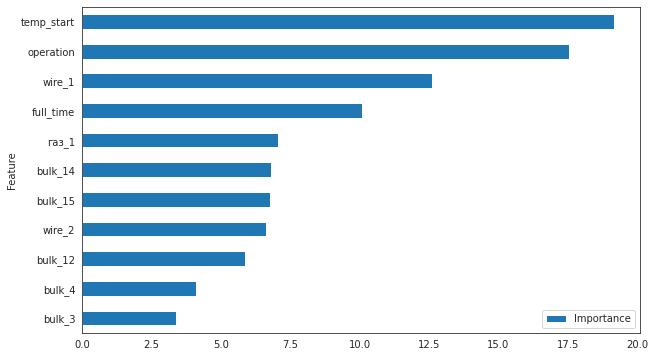

In [129]:
coefficients = model.feature_importances_
sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': X_test.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

Попробуем исключить 2 неважных признака bulk_3 и bulk_4

In [130]:
X_train_filtred = X_train.copy()
X_test_filtred = X_test.copy()
X_train_filtred = X_train_filtred.drop(columns=['bulk_3', 'bulk_4'])
X_test_filtred = X_test_filtred.drop(columns=['bulk_3', 'bulk_4'])

In [131]:
model.fit(X_train_filtred, y_train)
predictions = model.predict(X_test_filtred)
result = mean_absolute_error(y_test, predictions)
print(f'MAE: {result:.2f}')

MAE: 6.21


Метрика улучшилась. Именно исключение 2х признаков (ни больше, ни меньше) дает положительный результат.

In [132]:
# Проведем проверку на адекватность модели с помощью медианы 
dummy_clf = DummyRegressor(strategy='median')
dummy_clf.fit(X_train_filtred, y_train)
predictions = dummy_clf.predict(X_test_filtred)
result = mean_absolute_error(y_test, predictions)
print(f'MAE: {result:.2f}')

MAE: 7.84


На лучшей модели метрика приемлима.

## Общий вывод и рекомендации заказчику

Целями проекта являются построить модель, которая будет её предсказывать температуру сплава c точностью не более 6.8. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

Я загрузил данные в датафреймы pandas. Провел первичный осмотр. Содержание датафреймов соответствует заявленому описанию данных, кроме того, что в файлах data_wire_new и data_wire_time_new заявлено в описании, что Wire 1 … Wire 15 признаков будет 15, а их 9шт.

Выводы из иследовательского анализа:

Датафрейм data_arc_new

* В датафрейме всего 14876 объектов.
* 5 признаков: key номер партии по этому признаку буду соединять таблицы. Начало и конец нагрева стали преобразовал в тип datatime, но и этого мало для признака, в дальнейшем будем вычеслять дельты времени. Признаки Активная мощность и Реактивная мощность содержат числовые значения.
* Датафрейм не содержит пропусков и дупликатов.
* Признак Активная мощность данные распределены нормально от 0,2 до 1,4. При этом, вершина «колокола» нормального распределения смещена влево. Пик расположен на значении 0,45. Признак Реактивная мощность данные распределены нормально от 0,2 до 1,2. При этом, вершина «колокола» нормального распределения смещена влево. Пик расположен на значении 0,35.
* Есть одно аномальное наблюдение 9780. Для его обработки вычеслил значение ячейки с помощью пропопрцииональной зависимости активной и реактивной мощности через их средние значения и текущее значение активной мощности.
  
Датафрейм data_bulk_new

* В датафрейме всего 3129 объектов.
* 16 признаков: key номер партии. 15 видов сыпучих добавок.
* В каждом признаке есть пропуски - это значит в этой операции материал не добовлялся. Некоторые признаки имеют очень мало наблюдений. Например: bulk_2 22шт, bulk_7 25шт, bulk_8 1шт, bulk_13 18шт. Датафрейм не содержит дупликатов.
* Оставил в датафрейме признаки, имеющее более 1000 наблюдений (или 30% от общего количества).
* Признаки распрелелены нормально со смещение «колокола» влево.
  
Датафрейм data_bulk_time_new

* В датафрейме всего 3129 объектов, как и в предыдущем.
* 16 признаков: key номер партии. 15 времен подачи соответствующик добавок.
* В каждом признаке есть пропуски. Датафрейм не содержит дупликатов.
* Этот датафрейм не планирую использовать при обучении модели
  
Датафрейм data_gas_new

* В датафрейме всего 3239 объектов.
* 2 признака: key номер партии и объём подаваемого газа.
* Датафрейм не содержит пропусков и дупликатов.
  
Датафрейм data_temp_new

* В датафрейме всего 18092 объектов.
* 3 признака: key номер партии. Время замера температуры сплава и его температура
* Признак температура имеет пропуски. Их важно обработать, так как в данных содержится целевой признак (измерение темературы в конце каждого цикла) и еще один важный признак (температура в начале каждого цикла). Данные востоновлению не подлежат. Удаляем полностью все наблюдения в тех циклах, в которых отсутствует температура начала цикла или конечная. Датафрейм не содержит дупликатов.
* Признак температура распределен нормально. Есть 4 выброса - это начальные температуры сплавов. Выбросы решено оставить.
  
Датафрейм data_wire_new

* В датафрейме всего 3081 объектов.
* 10 признаков: key номер партии. 9 видов сыпучих добавок.
* В каждом признаке есть пропуски - это значит в этой операции материал не добовлялся. Некоторые признаки имеют очень мало наблюдений. Датафрейм не содержит дупликатов.
* Оставил в датафрейме признаки, имеющее более 1000 наблюдений (или 30% от общего количества).
Признаки распрелелены нормально со смещение «колокола» влево.

Датафрейм data_wire_time_new

* В датафрейме всего 3081 объектов, как и в предыдущем.
* 10 признаков: key номер партии. 9 времен подачи соответствующик добавок.
* В каждом признаке есть пропуски. Датафрейм не содержит дупликатов.
* Этот датафрейм не планирую использовать при обучении модели

* Во всех датафреймах переимменвал столбцы - привел к кириллическому_змеиному_языку.
* Во всех датафреймах разное количество наблюдении. При объединении данных часть наблюдений будет утрачена.

Для машинного обучения выделил 7 групп признаков:
* Целевой признак (target) Этот признак находится в датафрейме data_temp_new в столбце температура в ноблюдениях в конце технологического цикла
* Признак начальная температура берем также в датфрейме data_temp_new, только берем измерения проводимые в начале цикла.
* Признак работа получаем в датафрейме data_arc_new по фомуле вычесления Работы  A=sqtr(P**2+Q**2)*t причем все работы в цикле мы тоже складываем. В каждом объекте получем общюю работу.
* Признаки объёмы подаваемого материала bulks
* Признаки объёмы подаваемых проволочных материалов wires
* Признак объём подаваемого газа gas
* Признак общее время цикла full_time вычисляем полное время цикла. Данные берем в data_temp_new. Это разница между конечным и начальным измерением времени.
Во всех датафреймах разное количество наблюдении. При объединении данных часть наблюдений будет утрачена, а именн 2329 объекта

Высоких корреляций признаков между собой не наблюдается.

При подготовке данных выделил целевой признак и разделил данные на тренировочную и тестовую.

При обучении моделей применил модели: 
* Линейная регрессия
* Случайный лес
* LGBMRegresor
* CatBoost

В результате анализа моделей было выевлено что модель CatBoost с гиперпараметрами depth=5, learning_rate=0.1, n_estimators=600 лучше всего себя проявила на треноровочн

В итоге я получил модель пригодную для использование в бизнесе, отвечающую требованиям заказчика. 

Для того, чтобы модель улучшить предлагаю:

* Заказчику разобраться в причинах нулевых измерений температур. Это показатель важен для модели.
* Возможно есть возможность увеличить количество объектов за счет предостовления полной информации о каждом производственном цикле (Во всех датафреймах разное количество наблюдений по циклам).
* Можно попробывать другие модели, гиперпараметры, обработка выбросов, создание новых признаков.

Итоговая модель — CatBoostRegressor.

гиперпараметры: depth=5, learning_rate=0.05, n_estimators=500

Важные признаки: стартовая температура, работа в цикле, wire 1, время цикла, bulk 12, wire 2 и газ

Метрика: MAE на тестовой выборке MAE: 6.21